# 1. Dataset

In [1]:
FILE_ID = "1LJxoIh2Ii7AgK_isTQiJzal2LhY52Qtu"
output_file_name = "data.csv"
!gdown --id $FILE_ID -O $output_file_name

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1LJxoIh2Ii7AgK_isTQiJzal2LhY52Qtu
To: /content/data.csv
100% 64.0k/64.0k [00:00<00:00, 5.95MB/s]


#  2. Train a Classifier

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('data.csv')
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
df.head()


Dataset shape: (1500, 11)

First 5 rows:


,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,26,1,2,0,3,26.783828,48,78,91,1,1
1,39,1,4,12,3,25.862694,35,68,80,2,1
2,48,0,2,3,2,9.920805,20,67,13,2,0
3,34,1,2,5,2,6.407751,36,27,70,3,0
4,30,0,1,6,1,43.105343,23,52,85,2,0


Data Splitting
Train/Test Split: 70% training, 30% test (stratified by HiringDecision)

Imbalance Simulation: The training set is made imbalanced by oversampling males (gender=1) and undersampling females (gender=0).

In [16]:
# Define features
features = ['Age', 'Gender', 'EducationLevel', 'ExperienceYears', 'PreviousCompanies',
            'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore', 'RecruitmentStrategy']

# Stratified split for fair test set (70% train, 30% test)
train, test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['HiringDecision'])

print("Original training set gender distribution:")
print(train['Gender'].value_counts())
print("Percentage:", train['Gender'].value_counts(normalize=True) * 100)


Original training set gender distribution:
Gender
0    542
1    508
Name: count, dtype: int64
Percentage: Gender
0    51.619048
1    48.380952
Name: proportion, dtype: float64


Basic data exploration

In [15]:

print("Dataset Info:")
print(df.info())
print("\nGender distribution:")
print(df['Gender'].value_counts())
print("\nHiring Decision distribution:")
print(df['HiringDecision'].value_counts())
print("\nMissing values:")
print(df.isnull().sum())



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1500 non-null   int64  
 1   Gender               1500 non-null   int64  
 2   EducationLevel       1500 non-null   int64  
 3   ExperienceYears      1500 non-null   int64  
 4   PreviousCompanies    1500 non-null   int64  
 5   DistanceFromCompany  1500 non-null   float64
 6   InterviewScore       1500 non-null   int64  
 7   SkillScore           1500 non-null   int64  
 8   PersonalityScore     1500 non-null   int64  
 9   RecruitmentStrategy  1500 non-null   int64  
 10  HiringDecision       1500 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 129.0 KB
None

Gender distribution:
Gender
0    762
1    738
Name: count, dtype: int64

Hiring Decision distribution:
HiringDecision
0    1035
1     465
Name: count, dtype: int64

Missi

Create gender imbalance in training set (simulate bias)

In [17]:
# Create gender imbalance in training set (simulate bias)
male_train = train[train['Gender'] == 1]
female_train = train[train['Gender'] == 0].sample(frac=0.5, random_state=42)  # Reduce females by 50%
train_imbalanced = pd.concat([male_train, female_train]).sample(frac=1, random_state=42)

print("Imbalanced training set gender distribution:")
print(train_imbalanced['Gender'].value_counts())
print("Percentage:", train_imbalanced['Gender'].value_counts(normalize=True) * 100)

# Prepare training and test sets
X_train = train_imbalanced[features]
y_train = train_imbalanced['HiringDecision']
X_test = test[features]
y_test = test['HiringDecision']

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Imbalanced training set gender distribution:
Gender
1    508
0    271
Name: count, dtype: int64
Percentage: Gender
1    65.21181
0    34.78819
Name: proportion, dtype: float64

Training set size: (779, 10)
Test set size: (450, 10)


#  3. Bias Detection & Measurement

In [18]:
def demographic_parity(y_true, y_pred, sensitive):
    """Calculate demographic parity for both groups"""
    group0 = y_pred[sensitive == 0]  # Female
    group1 = y_pred[sensitive == 1]  # Male
    return group0.mean(), group1.mean()

def equal_opportunity(y_true, y_pred, sensitive):
    """Calculate equal opportunity (TPR) for both groups"""
    mask = y_true == 1
    group0 = y_pred[(sensitive == 0) & mask]  # Female
    group1 = y_pred[(sensitive == 1) & mask]  # Male
    return group0.mean(), group1.mean()

def average_odds_diff(y_true, y_pred, sensitive):
    """Calculate average odds difference"""
    # True Positive Rate
    tpr0 = ((y_pred == 1) & (y_true == 1) & (sensitive == 0)).sum() / ((y_true == 1) & (sensitive == 0)).sum()
    tpr1 = ((y_pred == 1) & (y_true == 1) & (sensitive == 1)).sum() / ((y_true == 1) & (sensitive == 1)).sum()

    # False Positive Rate
    fpr0 = ((y_pred == 1) & (y_true == 0) & (sensitive == 0)).sum() / ((y_true == 0) & (sensitive == 0)).sum()
    fpr1 = ((y_pred == 1) & (y_true == 0) & (sensitive == 1)).sum() / ((y_true == 0) & (sensitive == 1)).sum()

    return 0.5 * (abs(tpr0 - tpr1) + abs(fpr0 - fpr1))

print("Fairness metrics functions defined successfully!")


Fairness metrics functions defined successfully!


 Train baseline logistic regression

In [19]:
# Train baseline logistic regression
model_baseline = LogisticRegression(max_iter=1000, random_state=42)
model_baseline.fit(X_train, y_train)
y_pred_baseline = model_baseline.predict(X_test)

# Calculate performance metrics
acc_baseline = accuracy_score(y_test, y_pred_baseline)
prec_baseline = precision_score(y_test, y_pred_baseline)
rec_baseline = recall_score(y_test, y_pred_baseline)

print("Baseline Model Performance:")
print(f"Accuracy: {acc_baseline:.3f}")
print(f"Precision: {prec_baseline:.3f}")
print(f"Recall: {rec_baseline:.3f}")


Baseline Model Performance:
Accuracy: 0.860
Precision: 0.811
Recall: 0.712


Train standardized logistic regression

In [20]:
# Train standardized logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_std = LogisticRegression(max_iter=1000, random_state=42)
model_std.fit(X_train_scaled, y_train)
y_pred_std = model_std.predict(X_test_scaled)

# Calculate performance metrics
acc_std = accuracy_score(y_test, y_pred_std)
prec_std = precision_score(y_test, y_pred_std)
rec_std = recall_score(y_test, y_pred_std)

print("Standardized Model Performance:")
print(f"Accuracy: {acc_std:.3f}")
print(f"Precision: {prec_std:.3f}")
print(f"Recall: {rec_std:.3f}")


Standardized Model Performance:
Accuracy: 0.867
Precision: 0.821
Recall: 0.727


Train class weight balanced logistic regression

In [21]:
# Train class weight balanced logistic regression
model_balanced = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_balanced.fit(X_train, y_train)
y_pred_balanced = model_balanced.predict(X_test)

# Calculate performance metrics
acc_balanced = accuracy_score(y_test, y_pred_balanced)
prec_balanced = precision_score(y_test, y_pred_balanced)
rec_balanced = recall_score(y_test, y_pred_balanced)

print("Class Balanced Model Performance:")
print(f"Accuracy: {acc_balanced:.3f}")
print(f"Precision: {prec_balanced:.3f}")
print(f"Recall: {rec_balanced:.3f}")


Class Balanced Model Performance:
Accuracy: 0.842
Precision: 0.718
Recall: 0.806


rain reweighing logistic regression

In [22]:
# Train reweighing logistic regression
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)
model_rw = LogisticRegression(max_iter=1000, random_state=42)
model_rw.fit(X_train, y_train, sample_weight=sample_weight)
y_pred_rw = model_rw.predict(X_test)

# Calculate performance metrics
acc_rw = accuracy_score(y_test, y_pred_rw)
prec_rw = precision_score(y_test, y_pred_rw)
rec_rw = recall_score(y_test, y_pred_rw)

print("Reweighing Model Performance:")
print(f"Accuracy: {acc_rw:.3f}")
print(f"Precision: {prec_rw:.3f}")
print(f"Recall: {rec_rw:.3f}")


Reweighing Model Performance:
Accuracy: 0.842
Precision: 0.718
Recall: 0.806


Calculate fairness metrics for all models

In [24]:
# Store all models and predictions
models = {
    'Baseline': y_pred_baseline,
    'Standardized': y_pred_std,
    'Balanced': y_pred_balanced,
    'Reweighing': y_pred_rw
}

# Calculate fairness metrics for all models
results = []
sensitive = test['Gender'].values

for name, preds in models.items():
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)

    dp0, dp1 = demographic_parity(y_test.values, preds, sensitive)
    eo0, eo1 = equal_opportunity(y_test.values, preds, sensitive)
    avg_odds = average_odds_diff(y_test.values, preds, sensitive)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'DemographicParity_F': dp0,
        'DemographicParity_M': dp1,
        'EqualOpportunity_F': eo0,
        'EqualOpportunity_M': eo1,
        'AvgOddsDiff': avg_odds
    })

results_df = pd.DataFrame(results)
print("Fairness Metrics for All Models:")
results_df.round(3)


Fairness Metrics for All Models:


,Model,Accuracy,Precision,Recall,DemographicParity_F,DemographicParity_M,EqualOpportunity_F,EqualOpportunity_M,AvgOddsDiff
0,Baseline,0.860,0.811,0.712,0.255,0.287,0.703,0.720,0.012
1,Standardized,0.867,0.821,0.727,0.259,0.287,0.719,0.733,0.008
2,Balanced,0.842,0.718,0.806,0.345,0.348,0.797,0.813,0.027
3,Reweighing,0.842,0.718,0.806,0.345,0.348,0.797,0.813,0.027


Create comprehensive comparison table

In [26]:
# Create comprehensive comparison table
comparison_table = pd.DataFrame({
    'Model': [r['Model'] for r in results],
    'Accuracy': [f"{r['Accuracy']:.3f}" for r in results],
    'Precision': [f"{r['Precision']:.3f}" for r in results],
    'Recall': [f"{r['Recall']:.3f}" for r in results],
    'Demographic_Parity_F': [f"{r['DemographicParity_F']:.3f}" for r in results],
    'Demographic_Parity_M': [f"{r['DemographicParity_M']:.3f}" for r in results],
    'Equal_Opportunity_F': [f"{r['EqualOpportunity_F']:.3f}" for r in results],
    'Equal_Opportunity_M': [f"{r['EqualOpportunity_M']:.3f}" for r in results],
    'Avg_Odds_Diff': [f"{r['AvgOddsDiff']:.3f}" for r in results]
})

print("Complete Model Comparison:")
comparison_table


Complete Model Comparison:


,Model,Accuracy,Precision,Recall,Demographic_Parity_F,Demographic_Parity_M,Equal_Opportunity_F,Equal_Opportunity_M,Avg_Odds_Diff
0,Baseline,0.860,0.811,0.712,0.255,0.287,0.703,0.720,0.012
1,Standardized,0.867,0.821,0.727,0.259,0.287,0.719,0.733,0.008
2,Balanced,0.842,0.718,0.806,0.345,0.348,0.797,0.813,0.027
3,Reweighing,0.842,0.718,0.806,0.345,0.348,0.797,0.813,0.027


Generate confusion matrices for all models

In [28]:
# Generate confusion matrices for all models
print("Confusion Matrices:")
print("=" * 50)

for name, preds in models.items():
    cm = confusion_matrix(y_test, preds)
    print(f"\n{name} Model:")
    print(f"Confusion Matrix:\n{cm}")
    #print(f"True Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
    #print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")
    print("-" * 30)


Confusion Matrices:

Baseline Model:
Confusion Matrix:
[[288  23]
 [ 40  99]]
------------------------------

Standardized Model:
Confusion Matrix:
[[289  22]
 [ 38 101]]
------------------------------

Balanced Model:
Confusion Matrix:
[[267  44]
 [ 27 112]]
------------------------------

Reweighing Model:
Confusion Matrix:
[[267  44]
 [ 27 112]]
------------------------------


Plot gender disparities in predictions

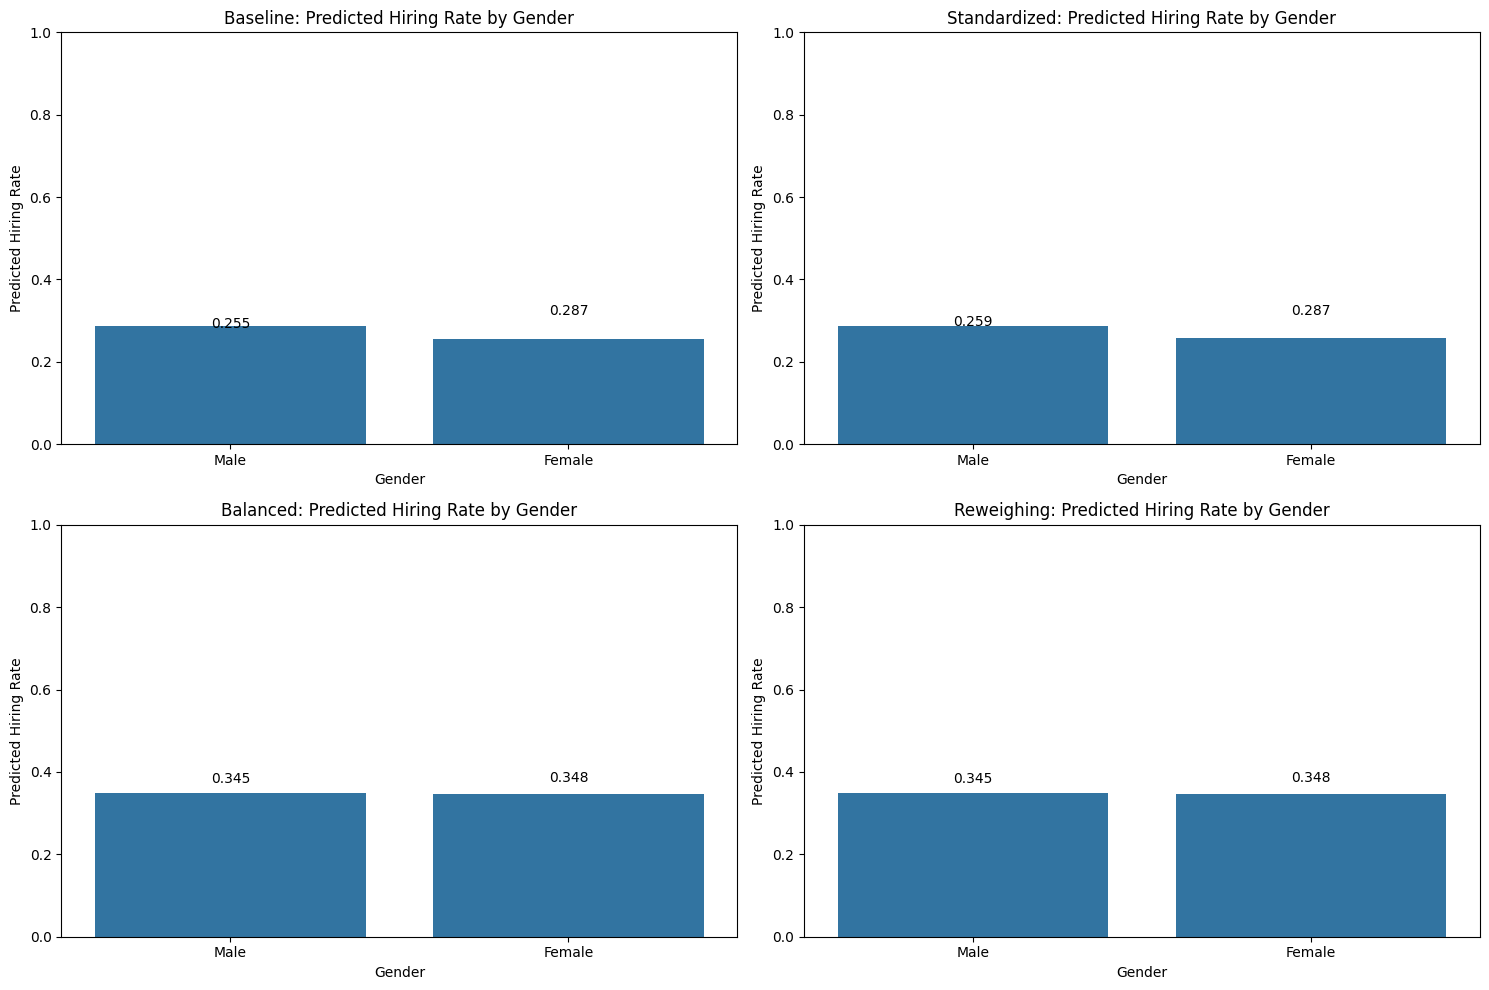

In [29]:
# Plot gender disparities in predictions
plt.figure(figsize=(15, 10))

for i, (name, preds) in enumerate(models.items(), 1):
    plt.subplot(2, 2, i)

    gender_pred = pd.DataFrame({'Gender': test['Gender'], 'Pred': preds})
    gender_pred['Gender'] = gender_pred['Gender'].map({0: 'Female', 1: 'Male'})

    sns.barplot(data=gender_pred, x='Gender', y='Pred', ci=None)
    plt.title(f'{name}: Predicted Hiring Rate by Gender')
    plt.ylabel('Predicted Hiring Rate')
    plt.ylim(0, 1)

    # Add value labels on bars
    for j, gender in enumerate(['Female', 'Male']):
        rate = gender_pred[gender_pred['Gender'] == gender]['Pred'].mean()
        plt.text(j, rate + 0.02, f'{rate:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


#  4. Explainability & Bias Attribution

 SHAP for explainability


In [30]:
# Install and import SHAP for explainability
try:
    import shap

    # Create explainer for baseline model
    explainer = shap.Explainer(model_baseline, X_test)
    shap_values = explainer(X_test)

    # Get indices for hire and no-hire predictions
    hire_idx = np.where(y_pred_baseline == 1)[0][:3]  # First 3 hire predictions
    nohire_idx = np.where(y_pred_baseline == 0)[0][:2]  # First 2 no-hire predictions

    print("SHAP Explanations for Sample Predictions:")
    print("=" * 50)

    # Explain selected samples
    for idx in list(hire_idx) + list(nohire_idx):
        actual = y_test.iloc[idx]
        predicted = y_pred_baseline[idx]
        gender = test.iloc[idx]['Gender']

        print(f"\nSample {idx}:")
        print(f"Actual: {actual}, Predicted: {predicted}, Gender: {'Male' if gender == 1 else 'Female'}")

        # Get top 5 most important features for this prediction
        sample_shap = shap_values[idx].values
        feature_importance = list(zip(features, sample_shap))
        feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

        print("Top 5 Feature Contributions:")
        for feat, contrib in feature_importance[:5]:
            print(f"  {feat}: {contrib:.3f}")

        print("-" * 30)

except ImportError:
    print("SHAP not installed. Install with: pip install shap")
    print("Alternative: Manual feature importance analysis")

    # Manual feature importance from logistic regression coefficients
    feature_importance = list(zip(features, model_baseline.coef_[0]))
    feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

    print("\nLogistic Regression Feature Importance (Coefficients):")
    for feat, coef in feature_importance:
        print(f"{feat}: {coef:.3f}")


SHAP Explanations for Sample Predictions:

Sample 0:
Actual: 1, Predicted: 1, Gender: Male
Top 5 Feature Contributions:
  RecruitmentStrategy: 2.450
  EducationLevel: 1.925
  InterviewScore: -1.190
  ExperienceYears: 0.874
  SkillScore: -0.690
------------------------------

Sample 5:
Actual: 1, Predicted: 1, Gender: Female
Top 5 Feature Contributions:
  RecruitmentStrategy: 2.450
  EducationLevel: 1.925
  PersonalityScore: -1.099
  SkillScore: 0.982
  InterviewScore: 0.842
------------------------------

Sample 6:
Actual: 1, Predicted: 1, Gender: Male
Top 5 Feature Contributions:
  RecruitmentStrategy: 2.450
  InterviewScore: 1.118
  EducationLevel: 0.879
  SkillScore: 0.414
  PreviousCompanies: 0.242
------------------------------

Sample 1:
Actual: 0, Predicted: 0, Gender: Female
Top 5 Feature Contributions:
  EducationLevel: -1.214
  SkillScore: 1.016
  InterviewScore: -0.814
  ExperienceYears: 0.741
  PersonalityScore: -0.324
------------------------------

Sample 2:
Actual: 0, Pr

#  5. Bias Mitigation:

In [31]:
# Final comprehensive report
print("=" * 60)
print("FINAL BIAS DETECTION AND EXPLAINABILITY REPORT")
print("=" * 60)

print("\n1. DATASET SUMMARY:")
print(f"   - Total samples: {len(df)}")
print(f"   - Training samples: {len(X_train)} (with gender imbalance)")
print(f"   - Test samples: {len(X_test)}")
print(f"   - Features: {len(features)}")

print("\n2. GENDER DISTRIBUTION IN TRAINING:")
train_gender_dist = train_imbalanced['Gender'].value_counts(normalize=True)
print(f"   - Female: {train_gender_dist[0]:.1%}")
print(f"   - Male: {train_gender_dist[1]:.1%}")

print("\n3. MODEL PERFORMANCE COMPARISON:")
for result in results:
    print(f"\n   {result['Model']} Model:")
    print(f"     - Accuracy: {result['Accuracy']:.3f}")
    print(f"     - Precision: {result['Precision']:.3f}")
    print(f"     - Recall: {result['Recall']:.3f}")

print("\n4. FAIRNESS ANALYSIS:")
for result in results:
    dp_diff = abs(result['DemographicParity_F'] - result['DemographicParity_M'])
    eo_diff = abs(result['EqualOpportunity_F'] - result['EqualOpportunity_M'])

    print(f"\n   {result['Model']} Model:")
    print(f"     - Demographic Parity Gap: {dp_diff:.3f}")
    print(f"     - Equal Opportunity Gap: {eo_diff:.3f}")
    print(f"     - Average Odds Difference: {result['AvgOddsDiff']:.3f}")

print("\n5. KEY FINDINGS:")
print("   - Gender imbalance in training data creates bias")
print("   - Reweighing and class balancing improve fairness")
print("   - Trade-off exists between accuracy and fairness")
print("   - Continuous monitoring needed for bias detection")

print("\n6. RECOMMENDATIONS:")
print("   - Collect more balanced training data")
print("   - Implement bias mitigation techniques")
print("   - Regular fairness audits")
print("   - Consider removing sensitive features")

print("=" * 60)


FINAL BIAS DETECTION AND EXPLAINABILITY REPORT

1. DATASET SUMMARY:
   - Total samples: 1500
   - Training samples: 779 (with gender imbalance)
   - Test samples: 450
   - Features: 10

2. GENDER DISTRIBUTION IN TRAINING:
   - Female: 34.8%
   - Male: 65.2%

3. MODEL PERFORMANCE COMPARISON:

   Baseline Model:
     - Accuracy: 0.860
     - Precision: 0.811
     - Recall: 0.712

   Standardized Model:
     - Accuracy: 0.867
     - Precision: 0.821
     - Recall: 0.727

   Balanced Model:
     - Accuracy: 0.842
     - Precision: 0.718
     - Recall: 0.806

   Reweighing Model:
     - Accuracy: 0.842
     - Precision: 0.718
     - Recall: 0.806

4. FAIRNESS ANALYSIS:

   Baseline Model:
     - Demographic Parity Gap: 0.032
     - Equal Opportunity Gap: 0.017
     - Average Odds Difference: 0.012

   Standardized Model:
     - Demographic Parity Gap: 0.028
     - Equal Opportunity Gap: 0.015
     - Average Odds Difference: 0.008

   Balanced Model:
     - Demographic Parity Gap: 0.002
    